In [1]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  #忽略烦人的警告
tf.logging.set_verbosity(tf.logging.ERROR)   #忽略烦人的警告
print(tf.__version__)
import numpy as np
from sklearn.decomposition import PCA

import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle   #对象存储用

from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib
import math

%matplotlib inline
matplotlib.rcParams['font.sans-serif'] = ['SimHei']

1.13.1


In [2]:
labelList = ["normal", "DoS", "PROBE", "U2R", "R2L"]
def load_obj(name):
    with open('./' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

distributions = {}
distributions['normal'] = load_obj("normal_Distribution_set")
distributions['DoS'] = load_obj("DoS_Distribution_set")
distributions['PROBE'] = load_obj("PROBE_Distribution_set")
distributions['U2R'] = load_obj("U2R_Distribution_set")
distributions['R2L'] = load_obj("R2L_Distribution_set")

attack_types = 4  #总已知攻击种类
feature_numbers = 12   #用于处理PSM的特征，位列前35的特征


#定义difference weight,取值0~1
def calculate_dw(distribution_1, distribution_2, feature_index):
    count1 = calculate_count(distribution_1, feature_index)
    count2 = calculate_count(distribution_2, feature_index)
    h = 20
    dw = 0
    for i in range(h):
        start = i*5
        end = start + 5
        T1 = distribution_1[str(feature_index)][str(start) + '-' + str(end)]/count1
        T2 = distribution_2[str(feature_index)][str(start) + '-' + str(end)]/count2
        dw += abs(T1 - T2)
    return dw/2
#用于计算分布字典里的实例数
def calculate_count(distribution, feature_index):
    h = 20
    count = 0
    for i in range(h):
        start = i*5
        end = start + 5
        count += distribution[str(feature_index)][str(start) + '-' + str(end)]
    return count
#定义hdw，hybird difference weight  第二个参数为：hdw应用的对应得分公式的对应的哪种字典
def calculate_hdw(feature_index, label):
    base = 0
    for key in distributions:
        if(key == label):
            continue
        dw = calculate_dw(distributions[label], distributions[key], feature_index)
        if(dw > base):
            base = dw
    return base


#计算例子在某种标签上的得分，需要提供对应标签, 这个标签的的分布统计字典
def get_score(example, distributeObj, label):    
    score = 0
    count = calculate_count(distributeObj, 0)  #取哪个特征都一样
    minBase = 1
    baseArr = []
    for i in range(feature_numbers):

        start = int(example[i]/0.05//1)*5   #取200个分组里的分组起始位置
        if(start == 100):     #特殊处理当该属性为1.0时溢出的情况
            start = 95      
        end = start + 5
        dataRange = '{0}-{1}'.format(start, end )
        base = distributeObj[str(i)][dataRange]/count
        if(base != 0 and base < minBase):
            minBase = base
        baseArr.append(base)
        
    for i in range(feature_numbers):
        if(baseArr[i] != 0):
            score += math.log(baseArr[i]) * calculate_hdw(i, label)  / feature_numbers
        else:
            score += math.log(minBase) * calculate_hdw(i, label)  / feature_numbers
            
    return score

distribution_feature = [    #产生的新特征
    'normal_Score', 'DoS_Score',
    'PROBE_Score', 'U2R_Score', 'R2L_Score'
]

def get_score_threshold(dataset_x, dataset_y):
    #5个分数数组，表示在这个label字典下label实例的得分情况
    Scores = {
        "normal" : [],
        "DoS" : [],
        "PROBE" : [],
        "U2R" : [],
        "R2L" : []
    }
    for i,item in enumerate(dataset_x):
        if(dataset_y.values[i].astype('int') == 0):
            
            Scores["normal"].append(get_score(item, distributions['normal'], 'normal'))
            
        elif(dataset_y.values[i].astype('int') == 1):
            
            Scores["DoS"].append(get_score(item, distributions['DoS'], 'DoS'))
            
        elif(dataset_y.values[i].astype('int') == 2):
            
            Scores["PROBE"].append(get_score(item, distributions['PROBE'], 'PROBE'))
            
        elif(dataset_y.values[i].astype('int') == 3):
            
            Scores["U2R"].append(get_score(item, distributions['U2R'], 'U2R'))
            
        elif(dataset_y.values[i].astype('int') == 4):
            
            Scores["R2L"].append(get_score(item, distributions['R2L'], 'R2L'))
            
    thresholds = []
    
    for item in Scores.values():
        item.sort()
        thresholds.append(item[len(item)//10])    #取”将样例分成1：9“的threshold
    return thresholds

def sigmoid(x):
    # TODO: Implement sigmoid function
    return 1/(1 + np.exp(-x))

def fill_score(i, item, Score_revert, label, label_num):
    #计算得分
    score = get_score(item, distributions[label], label)
    #score-normalization
    score_norm = sigmoid(score - thresholds[label_num])
    #放入要拼接的表
    Score_revert.loc[i, (label + '_Score')] = score_norm
    return

def create_distribution_score(dataset_x, thresholds):
    #创建空表
    Score_revert = pd.DataFrame(
        data=np.zeros(
            shape=(
                dataset_x.shape[0],
                len(distribution_feature)
            )
        ),columns = distribution_feature
    )
    #填充空表
    for i,item in enumerate(dataset_x):
        fill_score(i, item, Score_revert, 'normal', 0)
        fill_score(i, item, Score_revert, 'DoS', 1)
        fill_score(i, item, Score_revert, 'PROBE', 2)
        fill_score(i, item, Score_revert, 'U2R', 3)
        fill_score(i, item, Score_revert, 'R2L', 4)
            
    dataset_x = np.hstack((dataset_x,Score_revert.values))
    return dataset_x


In [3]:
def read_data():
    """
        读取数据，
        return
            train_dataset : 训练数据 
            test_dataset  ：测试数据
    """
    input_file_dir = "."
    train_file_name = "kddcup.data_10_percent"
    test_file_name = "corrected.txt"
    header_file_name = "header.txt"
    
    train_files = os.path.join(input_file_dir, train_file_name)
    test_files = os.path.join(input_file_dir, test_file_name)
    header_files = os.path.join(input_file_dir, header_file_name)
    
    with open(header_files, 'r') as f:
        header = f.readline().strip().split(',')
    train_dataset = pd.read_csv(train_files)
    test_dataset = pd.read_csv(test_files)
    train_dataset.columns = header
    test_dataset.columns = header
    dataset = train_dataset.append(test_dataset)
    return dataset
#选择需要进行创建字典的特征。实际有
def feature_selection(dataset):
    return dataset[[
        'src_bytes', 'dst_bytes', 'logged_in', 'count', 'srv_count', 'same_srv_rate', 
        'diff_srv_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 
        'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'protocol_type_icmp', 'flag_SF', 
        'service_ecr_i', 'service_http', 'labels'
    ]]

def split_valid_from_train(train_dataset, valid_size):
    # Method 1
    train_dataset, valid_dataset, _, _ = train_test_split(train_dataset, train_dataset['labels'], test_size=valid_size, random_state=None)
    # pandas中先重置index再打乱train. 否则只会调整各个行的顺序，而不会改变pandas的index
    # 重置
    train_dataset = train_dataset.reset_index(drop=True)
    # 打乱
    indexMask = np.arange(len(train_dataset))
    for i in range(10):
        np.random.shuffle(indexMask)
    train_dataset = train_dataset.iloc[indexMask]

    return train_dataset, valid_dataset

def shuffle(dataset):  
    # 打乱
    indexMask = np.arange(len(dataset))
    for i in range(10):
        np.random.shuffle(indexMask)
    dataset = dataset.iloc[indexMask]
    dataset = dataset.reset_index(drop=True)

    return dataset 

def labels_map(label):
    if(type(label) == int):      #已是数字，无需处理
        return label
    label = label.split('.')[0]
    
    DOS = ['apache2', 'back', 'land', 'mailbomb', 'neptune', 'pod', 
                  'processtable', 'smurf', 'teardrop', 'udpstorm'] #DOS 10个
    PROBE = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan'] #PROBE
    U2R = ['buffer_overflow', 'httptunnel', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm'] #U2R
    R2L = ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'named', 'phf', 
           'sendmail', 'snmpgetattack', 'snmpguess', 'spy', 'warezclient', 
           'warezmaster', 'worm', 'xlock', 'xsnoop']#R2L
    
    if label == 'normal':
        return 0
    if label in DOS:
        return 1
    if label in PROBE:
        return 2
    if label in U2R:
        return 3
    if label in R2L:
        return 4
    return -1
  
def filter_labels(dataset):
    dataset['labels'] = dataset['labels'].apply(labels_map)
    return dataset

def labels_separate(dataset):
    y_ = dataset['labels'].astype('int')
    temp = dataset
    temp.drop(['labels'], axis=1, inplace=True)
    x_ = temp.values
    return x_, y_


In [4]:
def one_hot_process(dataset):
    # 独热编码 protocol_type
    protocal_type_dummies = pd.get_dummies(dataset['protocol_type'], prefix='protocol_type')
    dataset = pd.concat([dataset, protocal_type_dummies], axis=1)
    dataset = dataset.drop(['protocol_type'], axis=1)
    # 独热编码 flag
    flag_dummies = pd.get_dummies(dataset['flag'], prefix='flag')
    dataset = pd.concat([dataset, flag_dummies], axis=1)
    dataset = dataset.drop(['flag'], axis=1)
    # 独热编码 service     （现阶段第三列数据对接有问题，暂时直接除掉这一条数据）
    service_dummies = pd.get_dummies(dataset['service'], prefix='service')
    dataset = pd.concat([dataset, service_dummies], axis=1)
    dataset = dataset.drop(['service'], axis=1)
    return dataset
#归一化整个数据集，注意要存储归一化的参数x_avg,x_max,x_min以便后面真实环境预处理需要
def normalization(dataset):
    epsilon = 0.0001   #防止除数为0
    dataset = dataset.astype('float')
    target_features = [
        'src_bytes', 'dst_bytes', 'logged_in', 'count', 'srv_count', 'same_srv_rate', 
        'diff_srv_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 
        'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate'
    ]
    
    norm_params = pd.DataFrame(np.zeros([3, len(target_features)]), columns=target_features)  #存储归一化参数
    
    for feature in dataset.columns.values.tolist():    #对列（特征名）进行遍历
        if feature in target_features:
            x = dataset[feature]
            x_avg = dataset[feature].mean()
            x_max = np.max(dataset[feature])
            x_min = np.min(dataset[feature])

            norm_params[feature] = [x_avg, x_max, x_min]
            dataset[feature] = (x - x_min) / (x_max - x_min + epsilon)
            #dataset = dataset.drop([feature], axis=1)
    return dataset,norm_params
    
def combine_dataset(trainDF, testDF):
    all = pd.concat([trainDF, testDF], axis=0)
    return all, (trainDF.shape[0], testDF.shape[0])

def separate_dataset(comb, num_comb):  
    train_dataset_size , test_dataset_size = num_comb
    trainDF = comb.iloc[:train_dataset_size]
    testDF = comb.iloc[train_dataset_size: (train_dataset_size + test_dataset_size)]
    return trainDF, testDF

   
def data_process_full(trainDF, testDF):
    all, num_comb = combine_dataset(trainDF, testDF)
    all = one_hot_process(all)
    all,norm_params = normalization(all)
    trainDF,testDF = separate_dataset(all, num_comb)
    return trainDF,testDF,norm_params

In [5]:
dataset = read_data()

dataset = filter_labels(dataset)


In [6]:
print(dataset.shape)
print(dataset.loc[:,'labels'].value_counts())

(805048, 42)
1    621311
0    157869
4     17315
2      8273
3       280
Name: labels, dtype: int64


In [7]:
normal_df = dataset.loc[dataset['labels'] == 0]
normal_df = normal_df.sample(n=80000,random_state=1, replace=False)
df_normal_train, df_normal_test = split_valid_from_train(normal_df, 0.2)

DOS_df = dataset.loc[dataset['labels'] == 1]
DOS_df = DOS_df.sample(n=100000,random_state=1, replace=False)
df_DOS_train, df_DOS_test = split_valid_from_train(DOS_df, 0.2)


PROBE_df = dataset.loc[dataset['labels'] == 2]
PROBE_df = PROBE_df.sample(n=5000,random_state=1, replace=True)
df_PROBE_train, df_PROBE_test = split_valid_from_train(PROBE_df, 0.2)


U2R_df = dataset.loc[dataset['labels'] == 3]
U2R_df = U2R_df.sample(n=1000,random_state=1, replace=True)
df_U2R_train, df_U2R_test = split_valid_from_train(U2R_df, 0.2)


R2L_df = dataset.loc[dataset['labels'] == 4]
R2L_df = R2L_df.sample(n=1000,random_state=1, replace=True)
df_R2L_train, df_R2L_test = split_valid_from_train(R2L_df, 0.2)

In [8]:
#整合
df_train = df_normal_train.append([df_DOS_train, df_PROBE_train, df_U2R_train, df_R2L_train])
df_test = df_normal_test.append([df_DOS_test, df_PROBE_test, df_U2R_test, df_R2L_test])

In [9]:
#独热编码和正则化
df_train, df_test, norm_params = data_process_full(
    df_train, df_test
)

In [10]:
#特征选择
df_train = feature_selection(df_train)
df_test = feature_selection(df_test)

In [11]:
print(df_train.shape)
print(df_train.loc[:,'labels'].value_counts())
print(df_test.shape)
print(df_test.loc[:,'labels'].value_counts())
print(df_train.columns)



(149600, 17)
1.0    80000
0.0    64000
2.0     4000
4.0      800
3.0      800
Name: labels, dtype: int64
(37400, 17)
1.0    20000
0.0    16000
2.0     1000
3.0      200
4.0      200
Name: labels, dtype: int64
Index(['src_bytes', 'dst_bytes', 'logged_in', 'count', 'srv_count',
       'same_srv_rate', 'diff_srv_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'protocol_type_icmp', 'flag_SF', 'service_ecr_i', 'service_http',
       'labels'],
      dtype='object')


In [12]:
#分离标签
df_train_X, df_train_y = labels_separate(df_train)
df_test_X, df_test_y = labels_separate(df_test)

In [13]:
thresholds = get_score_threshold(df_train_X, df_train_y)

In [14]:
print(thresholds)

[-0.8954438339142264, -0.8548290641269687, -1.0675659894957632, -0.945461318612093, -0.7859629842535897]


In [15]:
df_train_X = create_distribution_score(df_train_X, thresholds)

In [16]:
df_test_X = create_distribution_score(df_test_X, thresholds)

In [17]:
df_train_y = df_train_y.astype('int')
df_test_y = df_test_y.astype('int')

In [18]:
print(df_train_X.shape)
print(df_test_X.shape)
print(df_train_y.shape)

(149600, 21)
(37400, 21)
(149600,)


In [19]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from tensorflow.keras.layers import BatchNormalization
#超参数设置
learning_rate = 0.001
epochs = 10
batch_size = 256
activation = tf.nn.relu         #非输出层下的激活函数

In [104]:
#用于记录训练中每个batch的loss
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_losses_per_batch = []
        self.train_losses_per_epoch = []
        self.valid_losses_per_epoch = []
        
    def on_batch_end(self, batch, logs={}):
        self.train_losses_per_batch.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs={}):
        self.train_losses_per_epoch.append(logs.get('loss'))
        self.valid_losses_per_epoch.append(logs.get('val_loss')*4)   #验证集由于只有1/4的训练集大小所以损失要乘以4
#用于记录训练中每个epoch的召回率，精确度以及f1 score
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        return

    def on_epoch_end(self, epoch, logs={}):
        predictions = self.model.predict(df_test_X)
        val_predict = np.argmax(predictions, axis=1)     #把独热编码转化成数字
        val_targ = df_test_y
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')
        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        return       
#回调：模型跑完epoch后选取最好的epoch模型保存，选取标准为验证集损失最小的那一个
checkpoint = keras.callbacks.ModelCheckpoint(      
    "./KDD_model.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    period=1
)
def simple_model():
    model = keras.Sequential([
        keras.layers.Dense(df_train_X.shape[1], activation=activation, input_shape=(df_train_X.shape[1],)),
        BatchNormalization(),
        keras.layers.Dense(64, activation=activation),
        BatchNormalization(),
        keras.layers.Dense(32, activation=activation),
        BatchNormalization(),
        keras.layers.Dense(16, activation=activation),
        BatchNormalization(),
        keras.layers.Dense(5,activation=tf.nn.softmax)
    ])
    model.compile(optimizer =tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy']
    )
    model.summary()
    history = LossHistory()
    metrics = Metrics()
    model.fit(
        df_train_X,df_train_y,
        validation_data=[df_test_X, df_test_y],
        batch_size=batch_size,epochs=epochs,
        callbacks=[history, metrics, checkpoint]
    )   
    return model,history,metrics
model,history,metrics = simple_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 21)                462       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 21)                84        
_________________________________________________________________
dense_61 (Dense)             (None, 64)                1408      
_________________________________________________________________
batch_normalization_v1_46 (B (None, 64)                256       
_________________________________________________________________
dense_62 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_v1_47 (B (None, 32)                128       
_________________________________________________________________
dense_63 (Dense)             (None, 16)                528       
__________

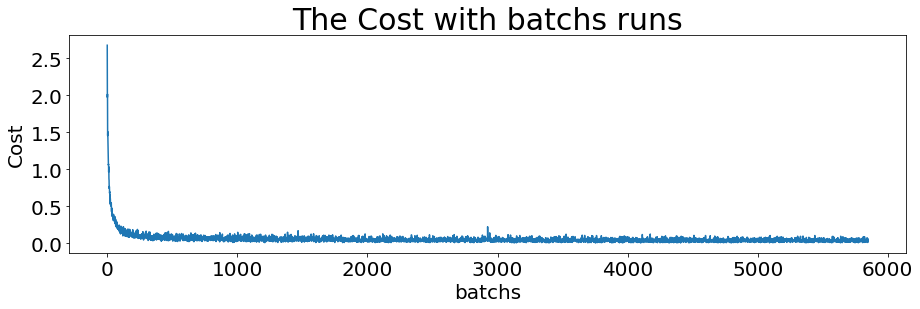

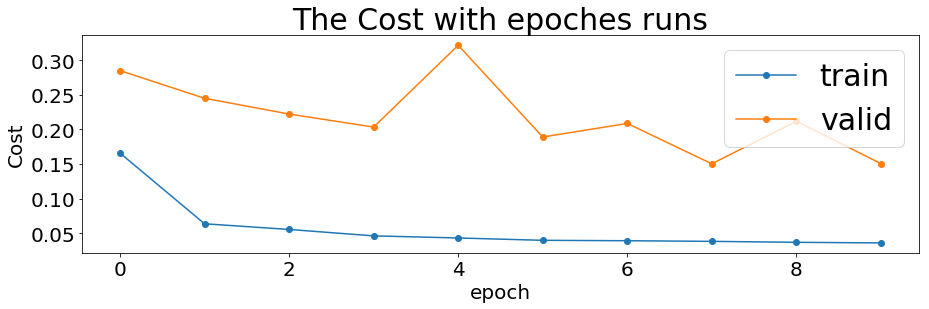

In [105]:
#绘制训练集在batch下的损失变化
plt.title('The Cost with batchs runs',fontsize=30)
plt.xlabel('batchs',fontsize=20)
plt.ylabel('Cost',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(history.train_losses_per_batch)
plt.gcf().set_size_inches(15,4)
plt.show()
#绘制训练集与验证集在epoch下的损失比较
plt.title('The Cost with epoches runs',fontsize=30)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('Cost',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(history.train_losses_per_epoch, '-o', label='train')
plt.plot(history.valid_losses_per_epoch, '-o', label='valid')
plt.legend(fontsize=30,loc='upper right')
plt.gcf().set_size_inches(15,4)
plt.show()

In [106]:
#选取验证集准确率最高的模型
model = keras.models.load_model('./KDD_model.h5') 
model.compile(optimizer =tf.train.AdamOptimizer(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
#测试集的正确率
def use_evaluate_test():
    test_loss,test_acc = model.evaluate(df_test_X,df_test_y)
    print('Test accuracy:', test_acc)
    return 
use_evaluate_test()

37400/37400 [==============================] - 11s 290us/sample - loss: 0.0376 - acc: 0.9890
Test accuracy: 0.9890107


In [107]:
predictions = model.predict(df_test_X)
print(classification_report(df_test_y, np.argmax(predictions, axis=1) , target_names=labelList))

              precision    recall  f1-score   support

      normal       0.98      1.00      0.99     16000
         DoS       1.00      1.00      1.00     20000
       PROBE       0.96      0.95      0.95      1000
         U2R       0.78      0.57      0.66       200
         R2L       0.97      0.20      0.33       200

   micro avg       0.99      0.99      0.99     37400
   macro avg       0.94      0.74      0.78     37400
weighted avg       0.99      0.99      0.99     37400



In [24]:
##############

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


# 运行程序
clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=3)
dt_clf = clf.fit(df_train_X, df_train_y)

In [26]:
predictions = dt_clf.predict(df_test_X)
print(predictions)
print(accuracy_score(df_test_y, predictions))

[0 0 0 ... 0 4 0]
0.9954812834224599


In [39]:
score = 0
for i in range(5):
    clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=3)
    clf.fit(df_train_X, df_train_y)
    y_pred = clf.predict(df_test_X)
    result = clf.score(df_test_X, df_test_y)
    if(score < result):
        score = result
        print(score)
        print(classification_report(df_test_y, y_pred, target_names=labelList))
        

0.9954010695187165
              precision    recall  f1-score   support

      normal       0.99      1.00      0.99     16000
         DoS       1.00      1.00      1.00     20000
       PROBE       0.99      0.98      0.99      1000
         U2R       0.92      0.96      0.94       200
         R2L       0.96      0.49      0.65       200

   micro avg       1.00      1.00      1.00     37400
   macro avg       0.97      0.89      0.91     37400
weighted avg       1.00      1.00      0.99     37400

0.9955347593582887
              precision    recall  f1-score   support

      normal       0.99      1.00      0.99     16000
         DoS       1.00      1.00      1.00     20000
       PROBE       0.99      0.98      0.98      1000
         U2R       0.93      0.96      0.95       200
         R2L       0.97      0.50      0.66       200

   micro avg       1.00      1.00      1.00     37400
   macro avg       0.98      0.89      0.92     37400
weighted avg       1.00      1.00      

In [40]:
score = 0
for i in range(5):
    clf = DecisionTreeClassifier(criterion='gini', min_samples_leaf=3)
    clf.fit(df_train_X, df_train_y)
    y_pred = clf.predict(df_test_X)
    result = clf.score(df_test_X, df_test_y)
    if(score < result):
        score = result
        print(score)
        print(classification_report(df_test_y, y_pred, target_names=labelList))
        

0.9947326203208556
              precision    recall  f1-score   support

      normal       0.99      1.00      0.99     16000
         DoS       1.00      1.00      1.00     20000
       PROBE       0.98      0.97      0.98      1000
         U2R       0.91      0.96      0.93       200
         R2L       0.95      0.49      0.65       200

   micro avg       0.99      0.99      0.99     37400
   macro avg       0.97      0.88      0.91     37400
weighted avg       0.99      0.99      0.99     37400

0.994812834224599
              precision    recall  f1-score   support

      normal       0.99      1.00      0.99     16000
         DoS       1.00      1.00      1.00     20000
       PROBE       0.98      0.97      0.98      1000
         U2R       0.91      0.95      0.93       200
         R2L       0.97      0.49      0.65       200

   micro avg       0.99      0.99      0.99     37400
   macro avg       0.97      0.88      0.91     37400
weighted avg       0.99      0.99      0

In [27]:
from sklearn.ensemble import RandomForestClassifier
score = 0
for i in range(5):
    rfc = RandomForestClassifier()
    rfc.fit(df_train_X, df_train_y)
    y_pred = rfc.predict(df_test_X)
    result = rfc.score(df_test_X, df_test_y)
    if(score < result):
        score = result
        print(score)
        print(classification_report(df_test_y, y_pred, target_names=labelList))
        
#测试集的正确率
#测试集的各个参数

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9956417112299465
              precision    recall  f1-score   support

      normal       0.99      1.00      1.00     16000
         DoS       1.00      1.00      1.00     20000
       PROBE       0.99      0.97      0.98      1000
         U2R       0.98      0.98      0.98       200
         R2L       0.98      0.48      0.65       200

   micro avg       1.00      1.00      1.00     37400
   macro avg       0.99      0.89      0.92     37400
weighted avg       1.00      1.00      1.00     37400



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9957219251336898
              precision    recall  f1-score   support

      normal       0.99      1.00      1.00     16000
         DoS       1.00      1.00      1.00     20000
       PROBE       0.99      0.98      0.98      1000
         U2R       0.99      0.99      0.99       200
         R2L       0.94      0.48      0.64       200

   micro avg       1.00      1.00      1.00     37400
   macro avg       0.98      0.89      0.92     37400
weighted avg       1.00      1.00      1.00     37400



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

In [28]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

score = 0
for i in range(5):
    xgb = XGBClassifier()
    xgb.fit(df_train_X, df_train_y)
    y_pred = xgb.predict(df_test_X)
    result = xgb.score(df_test_X, df_test_y)
    if(score < result):
        score = result
        print(score)
        print(classification_report(df_test_y, y_pred, target_names=labelList))
        
#测试集的正确率
#测试集的各个参数

0.9912566844919786
              precision    recall  f1-score   support

      normal       0.98      1.00      0.99     16000
         DoS       1.00      1.00      1.00     20000
       PROBE       0.96      0.96      0.96      1000
         U2R       0.86      0.74      0.80       200
         R2L       0.92      0.22      0.35       200

   micro avg       0.99      0.99      0.99     37400
   macro avg       0.95      0.78      0.82     37400
weighted avg       0.99      0.99      0.99     37400



In [29]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(df_train_X, df_train_y) 


/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [30]:
predictions = clf.predict(df_test_X)
print(predictions)
print(accuracy_score(df_test_y, predictions))
print(classification_report(df_test_y, predictions , target_names=labelList))

[0 0 0 ... 0 0 0]
0.9813636363636363
              precision    recall  f1-score   support

      normal       0.97      1.00      0.98     16000
         DoS       1.00      0.99      0.99     20000
       PROBE       0.93      0.88      0.90      1000
         U2R       0.73      0.40      0.52       200
         R2L       0.00      0.00      0.00       200

   micro avg       0.98      0.98      0.98     37400
   macro avg       0.73      0.65      0.68     37400
weighted avg       0.98      0.98      0.98     37400



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
